In [1]:
import cmocean.cm as cm
import copy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
from salishsea_tools import viz_tools
from scipy import signal

#### 1. Load in the data and plot 6 days from throughout the dataset

In [2]:
# open dataset - should be day-averaged
physics = xr.open_dataset('../../../../eosc510/SalishSeaCast_1d_salinity_20200101_20201231.nc')

In [3]:
phys_arr = physics.vosaline.to_numpy()  # go from an xarray to a numpy array

In [4]:
num_days = phys_arr.shape[0]

# define dimensions for later reshaping
Nx = phys_arr.shape[2]
Ny = phys_arr.shape[3]

In [5]:
# make a mask of land where land is true and water in NaN
bathymetry = xr.open_dataset('../../../../MEOPAR/grid/bathymetry_201702.nc')
land = np.array(np.isnan(bathymetry.Bathymetry).to_numpy(), dtype='float')
land[land == 0] = np.nan

In [6]:
# make the indicies for plotting six sample salinity fields
plot_ind = np.array([[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]])
plot_day = np.array([0, 50, 100, 150, 200, 250])  # this selects what days of each year to plot, change for > 1 year

In [7]:
# open the mesh mask and use it to mask the land
mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask201702.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

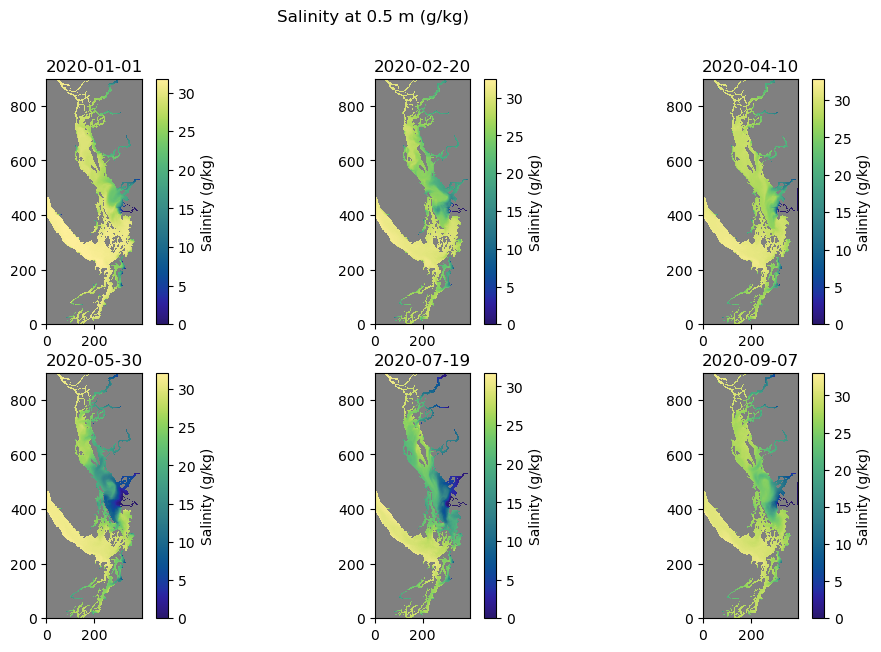

In [8]:
kd = 0 ## this will stay for surface
imin = 0
imax = 898
jmin = 0
jmax = 398
dm = physics

fig1, ax1 = plt.subplots(2, 3, figsize=(12, 7))

for i in np.arange(0,6):
    
    cmap = cm.haline
    cmap.set_bad('gray')

    
    day = plot_day[i]
    day_str = np.datetime_as_string(physics.time[day].values, unit='D')
    # salinity plot
    myarray = np.ma.array(dm.vosaline[day, kd, imin:imax, jmin:jmax])
    salinity = np.ma.masked_array(myarray, mask=tmask[0])
    colours = ax1[plot_ind[i][0], plot_ind[i][1]].pcolormesh(np.arange(jmin, jmax), np.arange(imin, imax), salinity, cmap=cm.haline, shading='auto')
    ax1[plot_ind[i][0], plot_ind[i][1]].set_title(day_str)
    cb = fig1.colorbar(colours, ax=ax1[plot_ind[i][0], plot_ind[i][1]])
    cb.set_label('Salinity (g/kg)')
    viz_tools.set_aspect(ax1[plot_ind[i][0], plot_ind[i][1]]);
    
    
fig1.suptitle(f'Salinity at {kd+0.5} m (g/kg)')
plt.savefig('2020_samplesal.png')

#### 2. Do PCA!

In [9]:
surface = phys_arr[:,0,:,:].reshape(num_days, 357404)
surface = np.nan_to_num(surface)

In [10]:
n_modes = np.min(np.shape(surface))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(surface)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

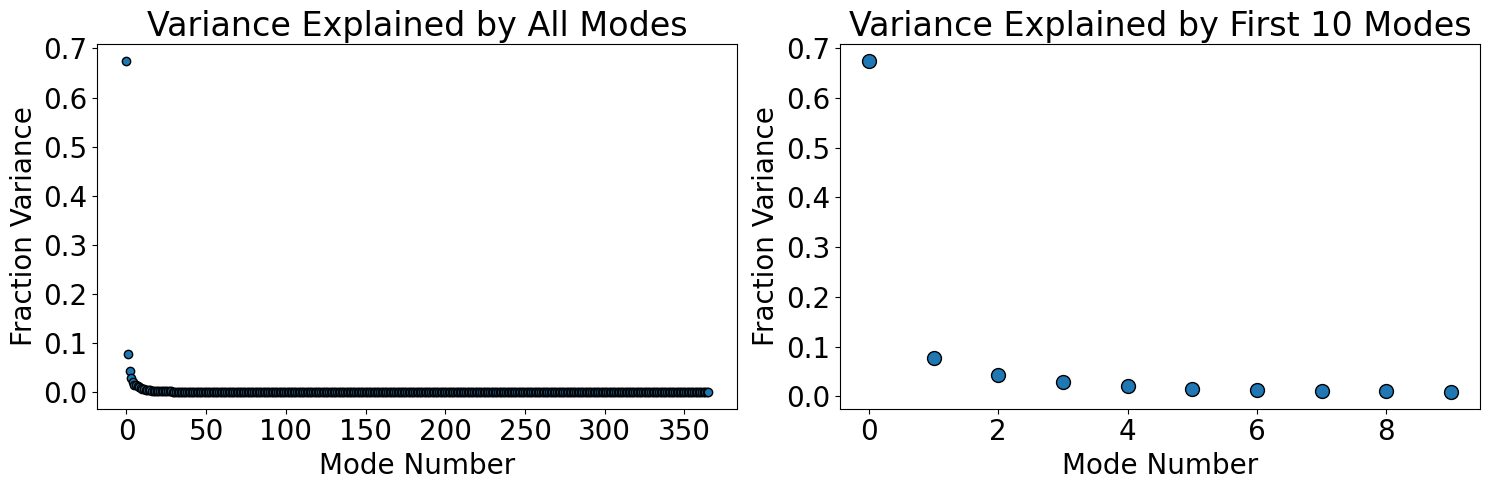

In [11]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar, edgecolor = 'k')
plt.xlabel('Mode Number', fontsize = 20)
plt.ylabel('Fraction Variance', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Variance Explained by All Modes', fontsize = 24)

plt.subplot(1,2,2)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar[:n_modes_show], s = 100, edgecolor = 'k')
plt.xlabel('Mode Number', fontsize = 20)
plt.ylabel('Fraction Variance', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes', fontsize = 24)

plt.tight_layout()

# if saveIt:
#     plt.savefig('tutorial4_fig3.png')

plt.show()

In [12]:
np.sum(fracVar[:5]) # fraction of variance explained by this many modes

0.8454014

In [13]:
## without the land mask applied on top
# #plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure!

# n = 5

# plt.figure(figsize=(25,5*n))
# for kk in range(n):
    
#     plt.subplot(n,2,kk*2+1)
# #     cmap.set_bad('gray')
    
# #     evec = np.ma.masked_array(np.flipud(np.reshape(eigvecs[kk],(Nx,Ny))), mask=tmask[0])
# #     colours = plt.pcolormesh(np.arange(jmin, jmax), np.arange(imin, imax), evec, cmap=cm.haline, shading='auto')
#     # plt.Axes.set_aspect('self','equal')
#     # plt.imshow(evec, cmap='RdBu_r')
#     # to_show = np.ma.masked_array(np.flipud(np.reshape(eigvecs[kk],(Nx,Ny))), mask=tmask[0])
#     # cb = plt.imshow(to_show, cmap='RdBu_r')
    
#     # plt.imshow(land)
#     cb = plt.imshow(np.flipud(np.reshape(eigvecs[kk],(Nx,Ny))), cmap='RdBu_r')
#     plt.colorbar(cb)
    
#     plt.subplot(n,2,(kk+1)*2)
#     plt.plot(PCs[:,kk], linewidth = 0.5)
#     plt.title('PCs of Mode #' + str(kk+1), fontsize = 24)
#     plt.xlabel('Day', fontsize = 20)
    
# plt.tight_layout()
    
# plt.show()

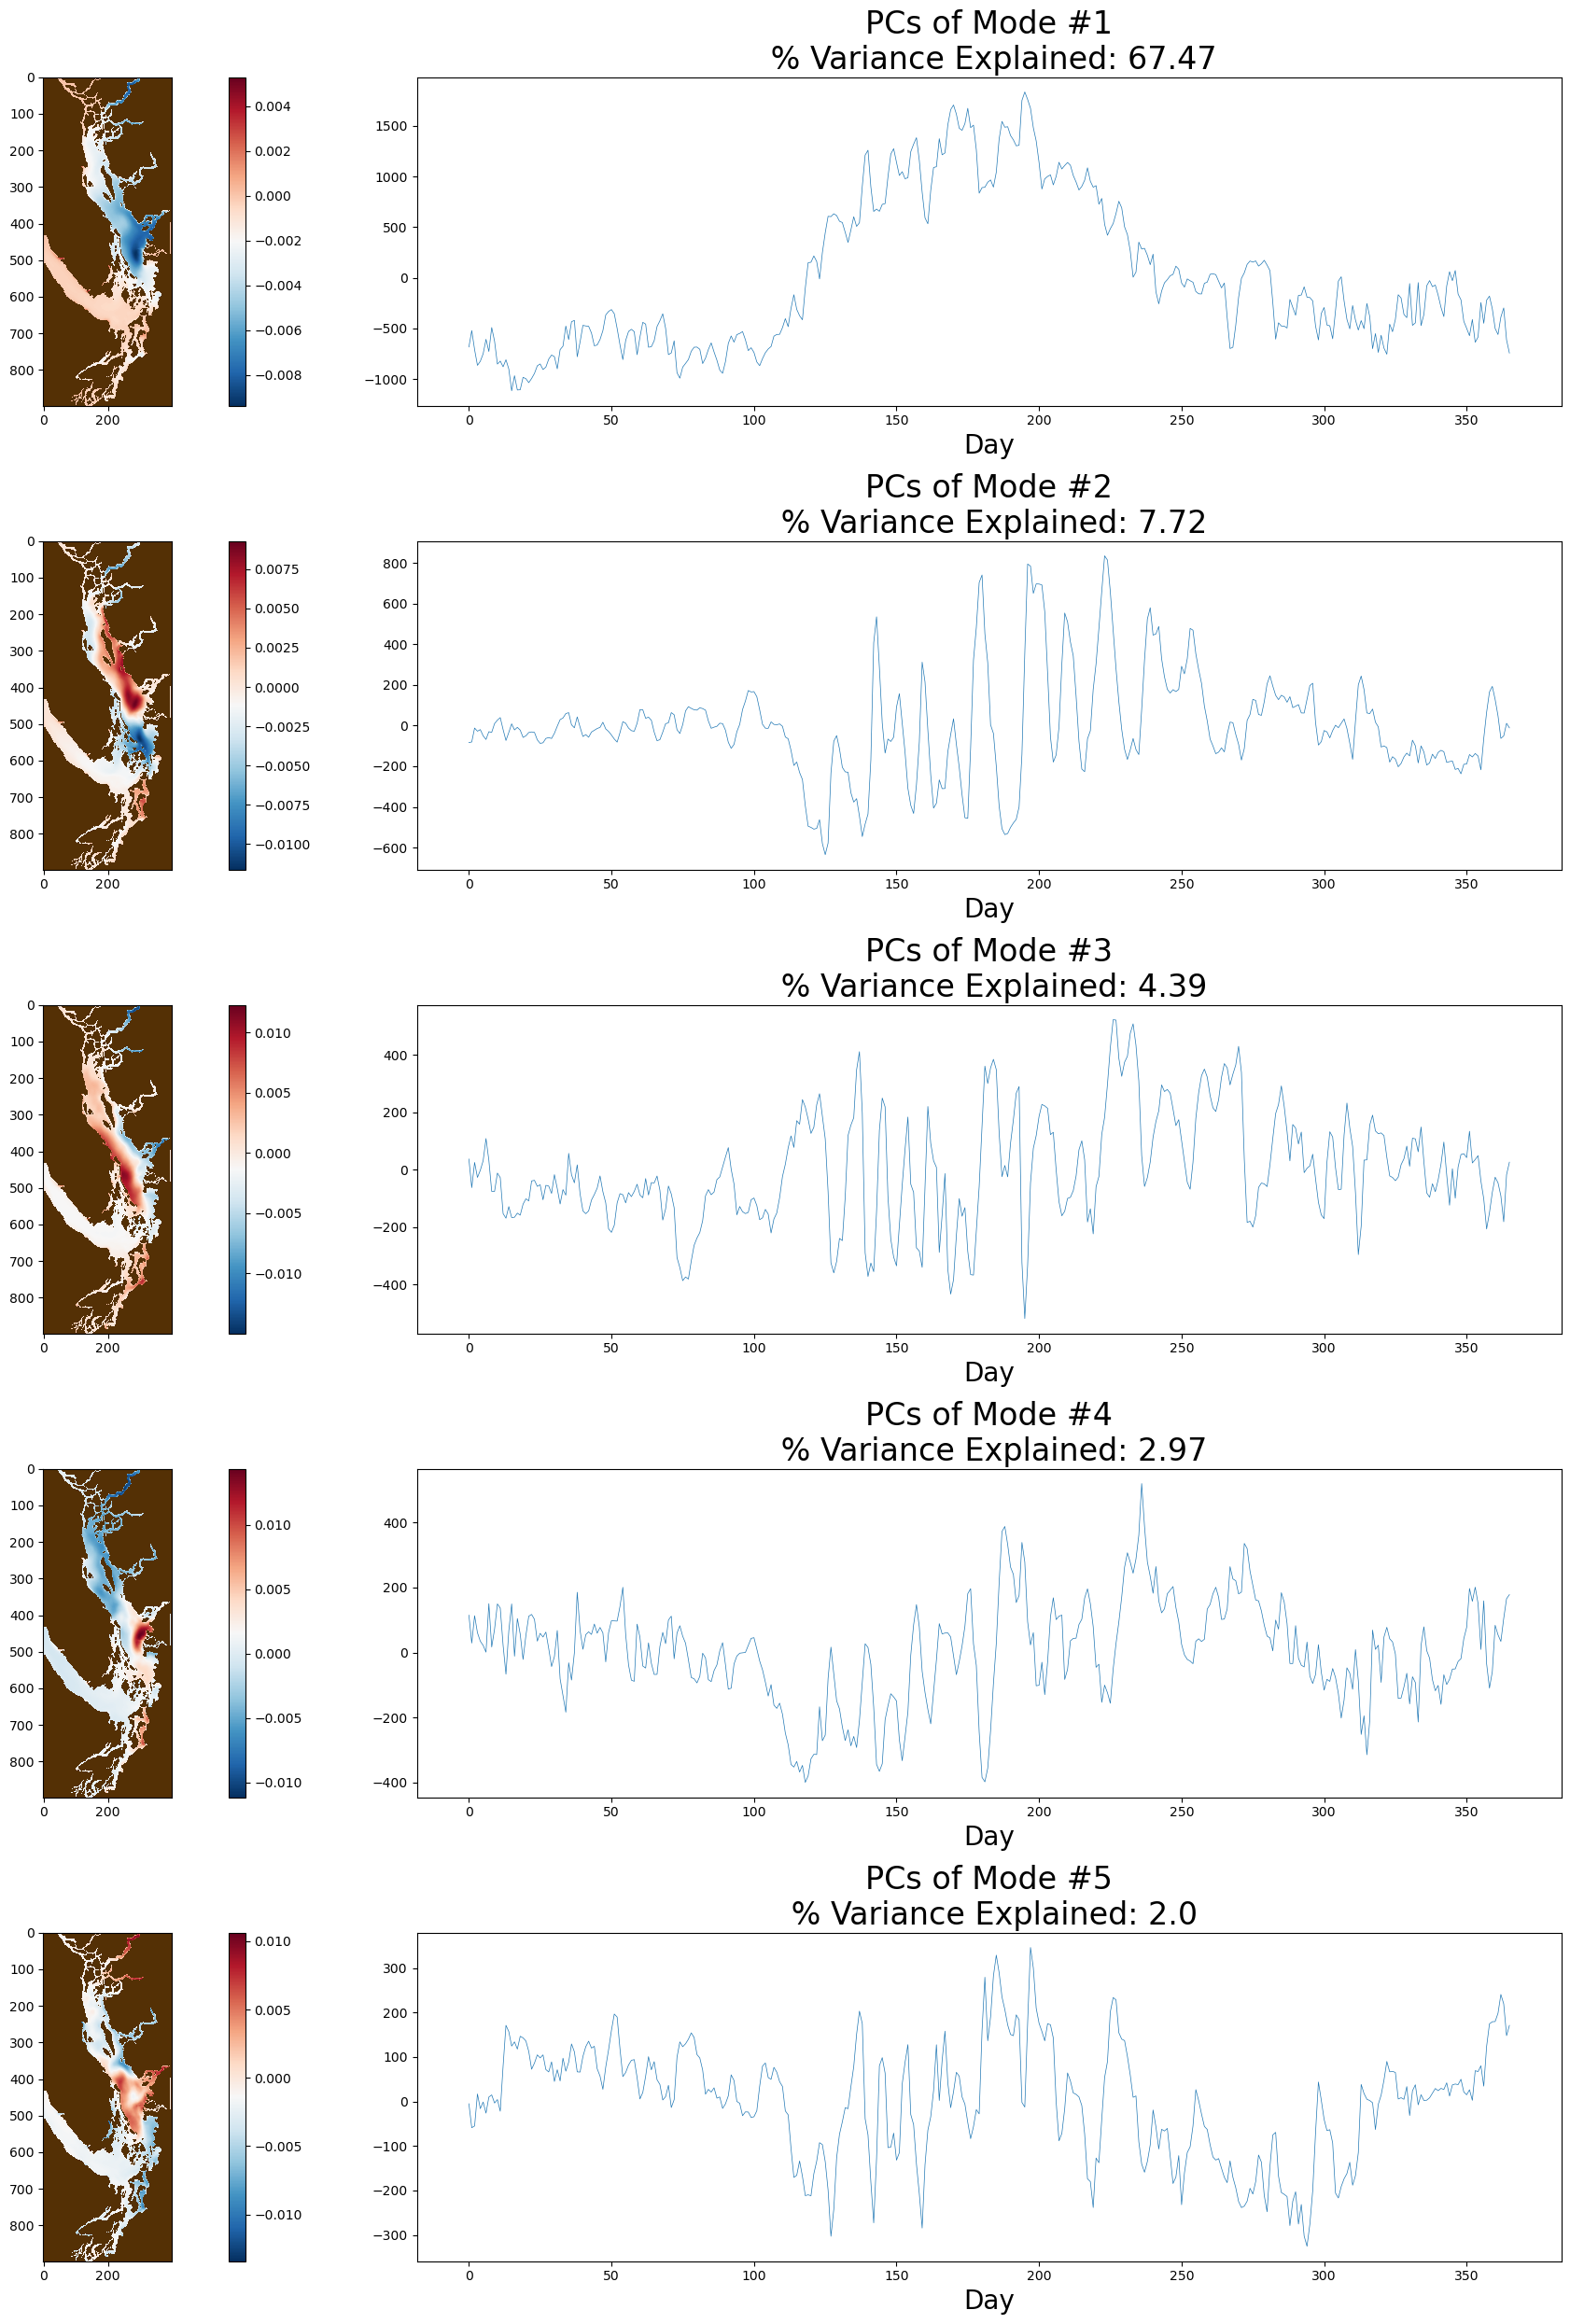

In [14]:
#plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure!

n = 5

fig2, ax2 = plt.subplots(n, 2, figsize=(25, 5*n))

for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    to_show = np.ma.masked_array(np.flipud(np.reshape(eigvecs[kk],(Nx,Ny))), mask=tmask[0])
    cb = ax2[kk,0].imshow(np.flipud(np.reshape(eigvecs[kk],(Nx,Ny))), cmap='RdBu_r')
    plt.colorbar(cb)
    cb2 = ax2[kk,0].pcolormesh(np.flipud(land), cmap='BrBG')  ################## want
    viz_tools.set_aspect(ax2[kk,0]);
    
    
    ax2[kk,1].plot(PCs[:,kk], linewidth = 0.5)
    ax2[kk,1].set_title('PCs of Mode #' + str(kk+1) + "\n % Variance Explained: " + str(round(100*fracVar[kk],2)), fontsize = 24)
    ax2[kk,1].set_xlabel('Day', fontsize = 20)
    
plt.tight_layout()

plt.savefig('2020_modes.png')
plt.show()

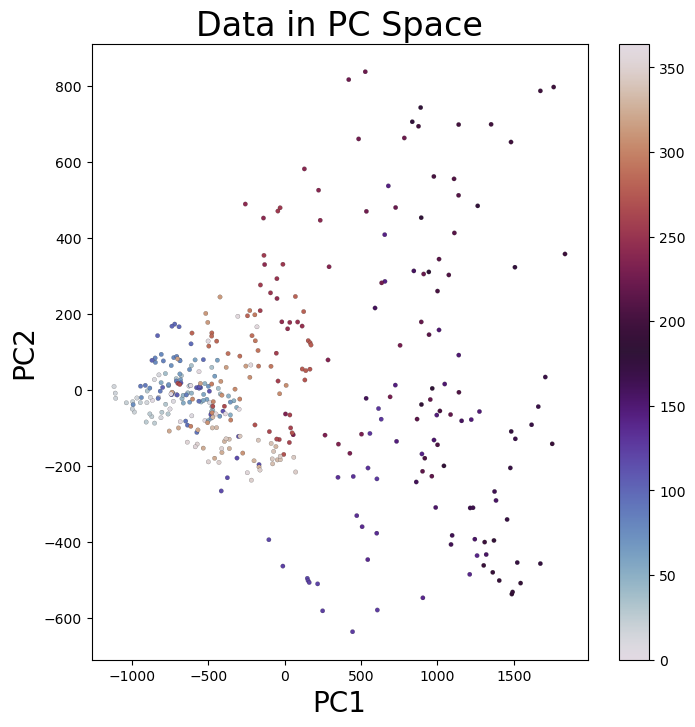

In [15]:
#plot PC1 vs PC2 -- coloured by day of year
Nobs = len(PCs)
day_of_year = np.array([kk%365 for kk in range(Nobs)])

saveIt = 0

plt.figure(figsize=(8,8))
plt.scatter(PCs[:,0],PCs[:,1],s=10,alpha=1, c = day_of_year, cmap = 'twilight', edgecolor = 'k', linewidth = 0.1)
plt.xlabel('PC1', fontsize = 20)
plt.ylabel('PC2', fontsize = 20)
plt.title('Data in PC Space', fontsize = 24)
plt.colorbar()

if saveIt:
    plt.savefig('2020_PCspace.png')

plt.show()

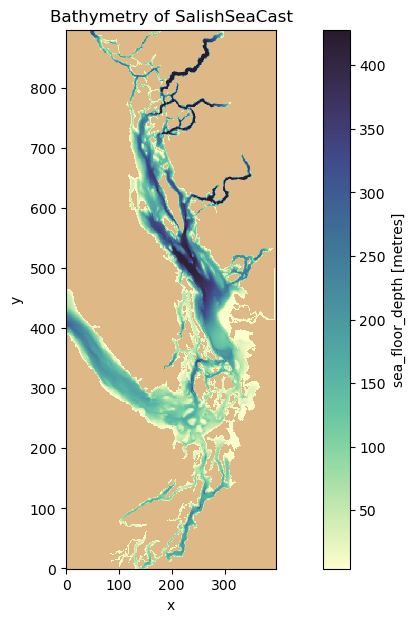

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
mycm = copy.copy(cm.deep)
mycm.set_bad('burlywood')
bathymetry.Bathymetry.plot(ax=ax, cmap=mycm);
ax.set_aspect(500/440)
ax.set_title('Bathymetry of SalishSeaCast');
fig.savefig('bathynorth.png')

In [17]:
## do some fourier on this
ts = PCs[:,1][100:200]
time = np.arange(len(PCs[:,0]))*86400  # time intervals in seconds

power_spec = signal.welch(ts, fs=1/86400, window='hann',nperseg=len(ts), nfft=len(ts))

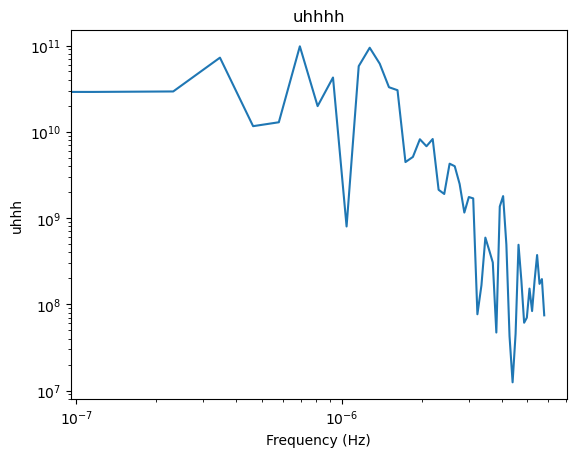

In [18]:
fig5, ax5 = plt.subplots()

ax5.plot(power_spec[0], power_spec[1])
ax5.set_xlabel('Frequency (Hz)')
ax5.set_ylabel('uhhh')
ax5.set_title('uhhhh')
ax5.set_xscale("log")
ax5.set_yscale("log")

plt.show()